In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df_input = pd.read_csv('Results.csv')
df_input = df_input.replace(-999.0000, np.NaN)
df_input.dropna()
df_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2460 entries, 0 to 2459
Data columns (total 19 columns):
Well           2460 non-null object
Depth          2460 non-null float64
GR             2460 non-null float64
NPHI           2460 non-null float64
RHOB           2460 non-null float64
PEF            2460 non-null float64
DT             2460 non-null float64
RD_LOG         2460 non-null float64
VSH            2460 non-null float64
SW             2460 non-null float64
KLOGH          2460 non-null float64
PHIF           2460 non-null float64
PHID           2460 non-null float64
N-D            2460 non-null float64
Cluster_all    2460 non-null int64
PCA_1          2460 non-null float64
PCA_2          2460 non-null float64
Id_discreto    2460 non-null int64
Lithofacies    2460 non-null object
dtypes: float64(15), int64(2), object(2)
memory usage: 365.3+ KB


##  Splitting & Standarizing data 

In [4]:
X = df_input.iloc[:, [14, 15, 16]]
Y = df_input.iloc[:, -2]
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2460 entries, 0 to 2459
Data columns (total 3 columns):
Cluster_all    2460 non-null int64
PCA_1          2460 non-null float64
PCA_2          2460 non-null float64
dtypes: float64(2), int64(1)
memory usage: 57.8 KB


In [5]:
# Train & Test Split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 1)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
Y_train.value_counts().sort_index()

1    566
2      6
3    601
4    471
5     55
6    200
7     28
8     41
Name: Id_discreto, dtype: int64

## Tunning Parameters for KNN

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [9]:
leaf_size = list(range(1,50))
p=[1,2]
k_neighbors = [1,3,5,7,9,11]

hyperparameters = dict(leaf_size = leaf_size, p = p, n_neighbors = k_neighbors)
knn_2 = KNeighborsClassifier()

clf = GridSearchCV(knn_2, hyperparameters, cv=10)

best_model = clf.fit(X_train,Y_train)

print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best k:', best_model.best_estimator_.get_params()['n_neighbors'])

/Users/Julio/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Best leaf_size: 1
Best p: 2
Best k: 5


## Applying KNN algorithm

In [13]:
# Training & predicting
knnmodel = KNeighborsClassifier(n_neighbors = 5, leaf_size =1, p=2, weights= 'uniform' )
knnmodel.fit(X_train, Y_train)
Y_predict1 = knnmodel.predict(X_test)

In [14]:
# Accuracy KNN
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
acc_knn = accuracy_score(Y_test, Y_predict1)
print('Accuracy:', round(acc_knn*100, 4) ,"%")

Accuracy: 62.3984 %


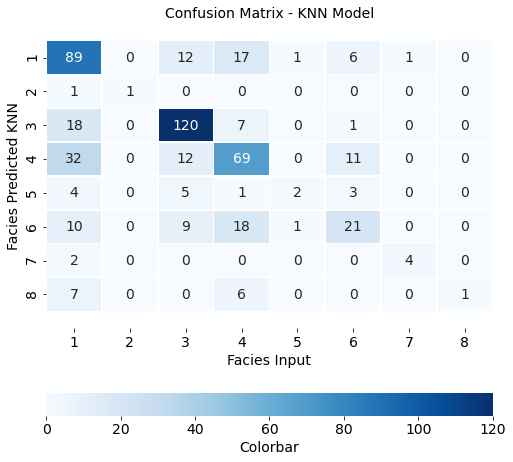

In [15]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sb
labels = np.unique(Y_test)
cm = confusion_matrix(Y_test.values, Y_predict1, labels = labels)
cm_knn =pd.DataFrame(cm, index = labels, columns = labels)

fig, ax =plt.subplots(figsize=(8,8))
plt.rcParams.update({'font.size': 14})
ax = sb.heatmap(cm_knn, fmt='d', annot=True, cmap= 'Blues', linewidths=.5, \
                cbar_kws={'label': 'Colorbar', 'orientation': 'horizontal'})
ax.figure.axes[-1].xaxis.label.set_size(14)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel("Facies Input",  fontsize=14)
plt.ylabel("Facies Predicted KNN",  fontsize=14)
plt.title('Confusion Matrix - KNN Model', fontsize=14)
plt.show()

### Threshold metrcis for model performance

In [16]:
Thm_single_knn = classification_report(Y_test.values, Y_predict1 , output_dict=True)
df_Thm_knn = pd.DataFrame(Thm_single_knn).transpose()
df_Thm_knn

,precision,recall,f1-score,support
1,0.546012,0.706349,0.615917,126.000000
2,1.000000,0.500000,0.666667,2.000000
3,0.759494,0.821918,0.789474,146.000000
4,0.584746,0.556452,0.570248,124.000000
5,0.500000,0.133333,0.210526,15.000000
6,0.500000,0.355932,0.415842,59.000000
7,0.800000,0.666667,0.727273,6.000000
8,1.000000,0.071429,0.133333,14.000000
accuracy,0.623984,0.623984,0.623984,0.623984
macro avg,0.711281,0.476510,0.516160,492.000000


## Tunning Parameters for SVM

In [17]:
from sklearn.svm import SVC

In [ ]:
rom sklearn.model_selection import GridSearchCV 
Cs = [0.001, 0.01, 0.1, 1, 10, 100]
gammas = [0.001, 0.01, 0.1, 1]
kernels = ['rbf', 'poly', 'sigmoid']
param_grid = {'C': Cs, 'gamma': gammas, 'kernel': kernels}

svc_2 = SVC()
grid = GridSearchCV(svc_2, param_grid, cv=10, refit = True, verbose=2)
grid.fit(X_train,Y_train)

In [ ]:
print(grid.best_estimator_)

## Applying SVM algorithm

In [18]:
svcmodel = SVC(gamma = 0.1, C = 100, kernel='rbf', random_state = None, shrinking = True, \
              decision_function_shape = 'ovo')
svcmodel.fit(X_train, Y_train)
Y_predict2 = svcmodel.predict(X_test)
acc_svc = accuracy_score(Y_test, Y_predict2)
print('Accuracy:', round(acc_svc*100, 4), '%')

Accuracy: 62.6016 %


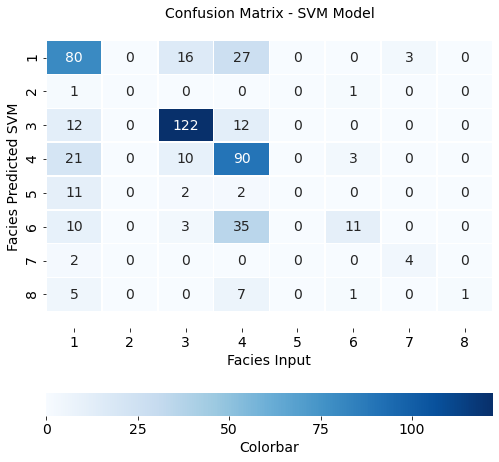

In [19]:
# confusion matrix
cm = confusion_matrix(Y_test.values, Y_predict2, labels = labels)
cm_svc =pd.DataFrame(cm, index = labels, columns = labels)

fig, ax =plt.subplots(figsize=(8,8))
ax = sb.heatmap(cm_svc, fmt='d', annot=True, cmap= 'Blues', linewidths=.5, \
                cbar_kws={'label': 'Colorbar', 'orientation': 'horizontal'})
ax.figure.axes[-1].xaxis.label.set_size(14)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel("Facies Input",  fontsize=14)
plt.ylabel("Facies Predicted SVM",  fontsize=14)
plt.title('Confusion Matrix - SVM Model', fontsize=14)
plt.show()

### Threshold metrcis for model performance

In [20]:
Thm_single_svc = classification_report(Y_test.values, Y_predict2 , output_dict=True)
df_Thm_svc = pd.DataFrame(Thm_single_svc).transpose()
df_Thm_svc

/Users/Julio/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
1,0.563380,0.634921,0.597015,126.000000
2,0.000000,0.000000,0.000000,2.000000
3,0.797386,0.835616,0.816054,146.000000
4,0.520231,0.725806,0.606061,124.000000
5,0.000000,0.000000,0.000000,15.000000
6,0.687500,0.186441,0.293333,59.000000
7,0.571429,0.666667,0.615385,6.000000
8,1.000000,0.071429,0.133333,14.000000
accuracy,0.626016,0.626016,0.626016,0.626016
macro avg,0.517491,0.390110,0.382648,492.000000
